In [1]:
from numpy import argsort
from sympy.physics.quantum import Commutator, Dagger, Operator
from sympy import *
import numpy as np
from IPython.display import display, Markdown, Latex, clear_output
from sympy.printing.latex import LatexPrinter
from useful import *
import matplotlib.pyplot as plt

In [2]:
def sep_sign(A):
    str_A = str(A)
    if str_A[0] == '-':
        return -1
    else: 
        return +1
    
def is_leaf(s):
    return 1 if len(s.args[:])==0 else 0

def can_expand(s):
    if isinstance(s, Commutator):
        a = 0
    else:
        l = len(s.args[:])
        if l == 1:
            a = 0
        elif l == 0:
            a = -1
        else:
            a = 1
    return a

def is_operator(s): # need to stop before leaf formed
    if isinstance(s, Operator):
        return 1
    else:
        if is_leaf(s):
            return 0#-1
        else:
            s_arg = s.args[:]
            if len(s_arg) == 1:
                s_arg = [s]
            for sa in s_arg:
                if is_operator(sa):
                    return 1
        return 0
    
def are_operators(S):
    ops = []
    for s in S:
        ops.append(is_operator(s))
    return ops

def print_if_op(S):
    if not isinstance(S, list):
        T = S.args
        if len(T) == 1:
            T = [S]
    else: 
        T = S
    for s in T:
        print(is_operator(s), '|', s)
            
def Separate_Op(A ): # Tokens must be a list of strings
    if can_expand(A):
        if A.is_Mul:
            counter = 0
            As = A.args[:]
            if len(As) == 1:
                As = [A]
            op_inds = []
            rest_inds = []
            for i, s in enumerate(As):
                if is_operator(s) == 1:
                    op_inds.append(i)
                else:
                    rest_inds.append(i)
            #print(As, '|', op_inds)
            A_op = Mul(*[As[op] for op in op_inds], evaluate=True)
            A_coeff = Mul(*[As[rest] for rest in rest_inds], evaluate=True)
            if sep_sign(A_op)==-1:
                A_op = -A_op
                A_coeff = -A_coeff
        else:
            A_op = []
            A_coeff = []
            B = A.args[:]
            if len(B) <= 1:
                B = [A]
            for b in B:
                op, coeff = Separate_Op(b )
                if isinstance(op,list):
                    for op1, coeff1 in zip(op,coeff):
                        A_op.append(op1)
                        A_coeff.append(coeff1)
                else:
                    A_op.append(op)
                    A_coeff.append(coeff)
    else:
        if is_operator(A):
            A_op = A
            A_coeff = 1
        else:
            A_op = 1
            A_coeff = A
        if sep_sign(A_op)==-1:
            A_op = -A_op
            A_coeff = -A_coeff
    return A_op, A_coeff

def Commutator_Collect(A):
    A_op, A_coeff = Separate_Op(A )
    if not isinstance(A_op, list):
        A_op = [A_op]
    if not isinstance(A_coeff, list):
        A_coeff = [A_coeff]
    i = 0
    A_op_str = [str(s) for s in A_op]
    new_terms = [] 
    if len(A_op_str) > 0:
        while len(A_op_str) > 0:
            c_str = A_op_str[i]
            i_list = [i]
            for j in range(i+1,len(A_op_str)):
                d_str = A_op_str[j]
                if c_str == d_str:
                    i_list.append(j)
            # Sum up relevant terms
            curr_coeff = [A_coeff[j] for j in i_list if not A_coeff[j]==0]
            Curr = factor(simplify(Add(*curr_coeff, evaluate = True)))
            new_terms.append(Mul(Curr, A_op[i], evaluate = True))
            # Remove used up terms
            while len(i_list) > 0:
                A_op.pop(i_list[-1])
                A_op_str.pop(i_list[-1])
                A_coeff.pop(i_list[-1])
                i_list.pop(-1)
        C =  Add(*new_terms)#, evaluate=False)
    else:
        C = A
    return C

In [3]:
def flatten(A):
    L = []
    for a in A:
        if isinstance(a, list):
            a_flat = flatten(a)
            for a_fl in a_flat:
                L.append(a_fl)
        else:
            L.append(a)
    return L
def Occurances_of(str_A, tokens):
    if not isinstance(str_A, list):
        if not isinstance(str_A, str):
            str_A = str(str_A)
        occurances = np.empty(len(tokens), dtype=int)
        for i, token in enumerate(tokens):
            occurances[i] = str_A.count(token)
    else:
        occurances = np.empty([len(str_A), len(tokens)], dtype=int)
        for i, stra in enumerate(str_A):
            occurances[i,:] = Occurances_of(stra, tokens)
    return occurances

def plus_sign(A):
    if not isinstance(A, list):
        A_str = str(A)
        if A_str[0] == '-':
            B = -A
        else:
            B = A
    else:
        B = A
        for i, a in enumerate(A):
            B[i] = plus_sign(a)
    return B

def total_plus_sign(A):
    if not isinstance(A, list):
        A_str = str(A)
        if A_str[0] == '-':
            tot_sign = -1
            B = -A
        else:
            tot_sign = +1
            B = A
    else:
        B = A
        tot_sign = +1
        for i, a in enumerate(A):
            c_tot_sign, B[i] = total_plus_sign(a)
            tot_sign = tot_sign*c_tot_sign
    return tot_sign, B

def remove_commutators(A):
    B = []
    for a in A:
        astr = str(a)
        if astr.count('[') == 0:
            # is not a commutator
            B.append(a)
    return B

def Group_Terms(D, max_braces = 2, group_rational = 0):
    if D.is_Add:
        # Split into terms
        term_list = []
        D_args = D.args[:]
        if len(D_args) == 1: # Don't expand into leaves
            D_args = [D]
        len_D = len(D_args)
        term_signs = np.empty(len_D, dtype=int)
        for i, d in enumerate(D_args):
            d_list = list(d.args[:])
            if len(d_list) == 0:
                d_list = [d]
            tot_sign, d_list = total_plus_sign(d_list)
            term_list.append(d_list)
            term_signs[i] = tot_sign
        flat_str = flatten(term_list)
        unique_terms = list(set(flat_str))
        #print(unique_terms)
        len_unique = len(unique_terms)
        # Count occurances and term lengths
        term_lengths = np.zeros(len_unique, dtype = int)
        occ_mat = np.zeros([len_D, len_unique], dtype = int)
        for i, unique_term in enumerate(unique_terms):
            term_lengths[i] = len(str(unique_term))  # Simplest measurement of complexity
            for j in range(len_D):
                occ_mat[j, i] = term_list[j].count(unique_term)
        # Perform sub group terms
        return Sub_Group_Terms(unique_terms, occ_mat, term_signs, max_braces, group_rational, adder = 0)
    else:
        return D # Nothing to do here
    
def Sub_Group_Terms(unique_terms, occ_mat, signs, max_braces=2,  group_rational = 0, adder = 0):
    len_unique = occ_mat.shape[1]
    if np.prod(occ_mat.shape) > 0:
        max_occ_sum = max(occ_mat)
        if max_braces > 0 and (len(occ_mat.shape) > 1 or  occ_mat.shape[0] > 1):
            # Find max occurance
            occ_sum = sum(occ_mat)
            if group_rational == 0:
                for i in range(len_unique):
                    if unique_terms[i].is_Rational:
                        occ_sum[i] = min(1,occ_sum[i])
            max_ind = np.argmax(occ_sum)
            max_occ_sum = max(occ_sum)
            if max_occ_sum > 1:
                # Separate in in and out groups
                term_indexes = np.where(occ_mat[:,max_ind])[0]
                remaining_indexes = np.where(1-occ_mat[:,max_ind])[0]
                sub_occ_mat = occ_mat[term_indexes,:]
                rem_occ_mat = occ_mat[remaining_indexes,:]
                sub_signs = signs[term_indexes]
                rem_signs = signs[remaining_indexes]
                # Group terms
                sub_occ_sum = sum(sub_occ_mat)
                if group_rational == 0:
                    for i in range(len_unique):
                        if unique_terms[i].is_Rational:
                            sub_occ_sum[i] = min(1,sub_occ_sum[i])
                len_sub = len(term_indexes)
                rem_occ_sum = sum(rem_occ_mat)
                len_rem = len(remaining_indexes)
                # Sub first
                max_loc = np.where(sub_occ_sum==len_sub)[0]
                reduced_terms = []
                for i in range(len(max_loc)):
                    reduced_terms.append(unique_terms[max_loc[i]]) 
                if np.all(sub_signs == -1):
                    shared_term = -Mul(*reduced_terms, evaluate=True)
                    sub_signs[:] = +1
                else:
                    shared_term = Mul(*reduced_terms, evaluate=True)
                sub_occ_sum[max_loc] = 0
                sub_occ_mat[:,max_loc] = 0
                new_shared_term = Sub_Group_Terms(unique_terms, sub_occ_mat, sub_signs, max_braces-len(max_loc), group_rational, adder = 0)
                if not new_shared_term == 1:
                    shared_term = shared_term*(new_shared_term)
                # Remaining second
                new_rem_term = Sub_Group_Terms(unique_terms, rem_occ_mat, rem_signs, max_braces, group_rational, adder = 1)
                if not new_rem_term == 0:
                    shared_term = shared_term+new_rem_term
        if max_braces <= 0 or max_occ_sum <= 1: #Add terms together in final inner brace
            len_D = occ_mat.shape[0]
            if len_D > 0:
                c_occ = occ_mat[0,:]
                locs = np.where(c_occ)[0]
                shared_term = factor(signs[0]*unique_terms[locs[0]])
                for j in range(1,len(locs)):
                    shared_term = Mul(shared_term, unique_terms[locs[j]], evaluate=True)

                for i in range(1,len_D):
                    c_occ = occ_mat[i,:]
                    locs = np.where(c_occ)[0]
                    curr_term = factor(signs[i]*unique_terms[locs[0]])
                    for j in range(1,len(locs)):
                        curr_term = Mul(curr_term, unique_terms[locs[j]], evaluate=True)
                    shared_term = shared_term + curr_term
            else:
                shared_term = 1 - adder
    else:
        shared_term = 1 - adder
    return shared_term

In [4]:
def Div(A, n):
    if A.is_Add:
        eq = []
        B = A.args[:]
        if len(B) <= 1: # Don't expand into leaves
            B = [A]
        for c in B:
            eq.append(Rational('1/'+str(n))*c)
        C = Add(*tuple(eq))
    else:
        C = Rational('1/'+str(n)) * A
    return C

def Multiply(A, n):
    if A.is_Add:
        eq = []
        B = A.args[:]
        if len(B) <= 1: # Don't expand into leaves
            B = [A]
        for b in B:
            eq.append(n*b)
        C = Add(*tuple(eq))
    else:
        C = n*A
    return C

def Get_Order(A, tokens ): # Tokens must be a list of strings
    if not A.is_Add:
        counter = 0
        A_str = str(A)
        for token in tokens:
            counter += A_str.count(token)
    else:
        counter = []
        B = A.args[:]
        if len(B) <= 1: # Don't expand into leaves
            B = [A]
        for b in B:
            counter.append(Get_Order(b, tokens ))
    return counter

def Reduce2Order(A, max_deg, tokens):  # Also sorts the terms
    counter = Get_Order(A, tokens )
    if not A.is_Add:
        if counter > max_deg:
            B = 0
        else:
            B = A
    else:
        C = A.args[:]
        if len(C) <= 1:
            C = [A]
        eq = []
        for i, c in enumerate(counter):
            if c <= max_deg:
                eq.append(C[i])
        B = Add(*eq, evaluate=False)
    return B

def Commutator_order(A,B, max_order, tokens):
    a_order = Get_Order(A, tokens )
    b_order = Get_Order(B, tokens )
    if not A.is_Add:
        al = [A]
        a_order = [a_order]
    else:
        al = A.args[:]
        if len(al) <= 1:
            al = [A]
    if not B.is_Add:
        bl = [B]
        b_order = [b_order]
    else:
        bl = B.args[:]
        if len(bl) <= 1:
            bl = [B]
    terms = []
    for ao, a in zip(a_order, al):
        for bo, b in zip(b_order, bl):
            if ao+bo <= max_order:
                ab_ba = Commutator(a,b)
                if not ab_ba == 0: 
                    terms.append(ab_ba)
    C = Add(*list(terms))
    return C

def Multi_Commutator_order(C, max_order, tokens):
    # C needs to be a list of commutators
    n = len(C)
    if n < 2:
        print('Multi Commutator needs to be at least of length len(C) >= 2 to be considered a commutator. ')
        raise ValueError
    D = C.reverse()
    E = Commutator_order(C[1], C[0], max_order, tokens) 
    for i in range(2, n):
        E = Commutator_order(C[i], E, max_order, tokens) 
    return E

In [5]:
def Separate_by_Order(C, tokens):
    if C.is_Add:
        a_s = C.args[:]
        if len(a_s) <= 1:
            a_s = [C]
        o_s = zeros(len(a_s), dtype=int)
        for i, a in enumerate(a_s):
            o_s[i] = Get_Order(a, tokens)
        o_max = max(o_s)
        terms = [0]*(o_max+1)
        for i, a in enumerate(a_s):
            curr_o = o_s[i]
            terms[curr_o] = terms[curr_o]+factor(a)
        return terms
    else:
        return [C]

def Connect_by_Order(Cs):
    D = factor(Add(*Cs, evaluate=True))
    return D

In [6]:
def simplify_add(T):
    if T.is_Add:
        Ts = list(T.args[:])
        n = len(Ts)
        op = []
        coeff = []
        for i, A in enumerate(Ts):
            curr_op, curr_coeff = Separate_Op(A)
            op.append(curr_op)
            coeff.append(curr_coeff)
        n = len(op)
        # Find equalities between operator combinations
        a_eq_pm_b = np.zeros([n,n], dtype=int)
        for i in range(n-1):
            o = op[i]
            for j in range(i+1,n):
                p = op[j]
                if simplify(o - p) == 0:
                    a_eq_pm_b[i,j] = 1
                    a_eq_pm_b[j,i] = 1
                elif simplify(o  + p) == 0:
                    a_eq_pm_b[i,j] = -1
                    a_eq_pm_b[j,i] = -1
        T_new_not_initialized = 1
        while len(op) > 1:
            inds = np.argwhere(a_eq_pm_b[0,:])[:,0]
            anti_inds = np.argwhere(a_eq_pm_b[0,:] == 0)[1:,0]
            coeff_inds = [coeff[0]]
            for ind in inds:
                coeff_inds.append(a_eq_pm_b[0,ind]*coeff[ind])
            total_coeff = simplify(Add(*coeff_inds, evaluate=True))
            if not total_coeff == 0:
                combined = Mul(*[op[0], total_coeff], evaluate=True)
                if T_new_not_initialized:
                    T_new = combined.copy()
                    T_new_not_initialized = 0
                else:
                    T_new = Add(*[T_new, combined], evaluate=True)
            # Remove terms
            a_eq_pm_b = a_eq_pm_b[np.ix_(anti_inds, anti_inds)]
            inds = np.sort(inds)
            inds = inds[::-1]
            for ind in inds:
                op.pop(ind)
                coeff.pop(ind)
            op.pop(0)
            coeff.pop(0)
        if len(op) == 1:
            combined = Mul(*[op[0], coeff[0]], evaluate=True)
            if T_new_not_initialized:
                T_new = combined
                T_new_not_initialized = 0
            else:
                T_new = Add(*[T_new, combined], evaluate=True)
    if T_new_not_initialized:
        T_new = 0
    return T_new

def Simplify_Commutator_Terms(D): # Go through the tree of terms
    D_new = D.copy()
    Dargs = list(D.args[:])
    if D.is_Mul:
        operator_indexes = np.where(are_operators(Dargs[:]))[0]
        for op_ind in operator_indexes:
            Dargs[op_ind] = Simplify_Commutator_Terms(Dargs[op_ind])
        return Mul(*Dargs, evaluate=True)
    elif D.is_Add: #Finally, the lowest level
        T_new = simplify_add(D_new)
        return T_new
    else:
        return D
    
def Solve_Commutator_Equalities(eq, tokens, optimize = 2):
    C = Separate_by_Order(eq, tokens=tokens)
    C_new = C.copy()
    for i in range(len(C_new)):
        curr_C = C[i]
        if not curr_C == 0:
            D = Group_Terms(curr_C, max_braces = optimize)
            C_new[i] = D
            if D.is_Add or D.is_Mul:
                D_new = list(D.args[:])
                operator_indexes = np.where(are_operators(D_new))[0]
                for op_ind in operator_indexes:
                    A = Simplify_Commutator_Terms(D_new[op_ind])
                    D_new[op_ind] = A#Simplify_Commutator_Terms(D.args[op_ind]) 
                if D.is_Add:
                    C_new[i] = Add(*D_new, evaluate=True)
                elif D.is_Mul:
                    C_new[i] = Mul(*D_new, evaluate=True)
    return C_new

def Cleanup(eq, tokens, optimize = 2):
    return Solve_Commutator_Equalities(eq, tokens, optimize)

In [7]:
def BCH_Order(A, B, max_order, tokens): # BCH up to commutator order [,^3]
    A = Reduce2Order(A, max_order, tokens)
    B = Reduce2Order(B, max_order, tokens)
    if max_order >= 2: # always limit to order 3
        Comm = Div(Commutator_order(A,B, max_order, tokens),'2')                                 # -1j    --> if exp(-1j*H) -> instead, here we use exp(H)
    if max_order >= 3:
        Comm = Add(Comm, Div(Multi_Commutator_order([A-B, A, B], max_order, tokens), '12'))      # -
    if max_order >=4:
        Comm = Add(Comm, -Div(Multi_Commutator_order([B, A, A, B], max_order, tokens), '24'))    # 1j*
    
    C = Add(*[A, B, Comm], evaluate=True)
    return C

def BCH_OC(A, B, max_order, op_tokens):
    C = BCH_Order(A, B, max_order, op_tokens)
    D = Commutator_Collect(C)
    return D

def Multi_BCH_OC(A_s, max_order, op_tokens):
    n = len(A_s)
    C = BCH_OC(A_s[0], A_s[1], max_order, op_tokens)
    for i in range(2,n):
        C = BCH_OC(C, A_s[i], max_order, op_tokens)
    return C

def Multi_BCH_Order(A_s, max_order, op_tokens):
    n = len(A_s)
    C = BCH_Order( A_s[0], A_s[1], max_order, op_tokens)
    for i in range(2,n):
        C = BCH_Order(C, A_s[i], max_order, op_tokens)
    return C

In [8]:
def findfirst(string, patterns):
    i = -1
    for p in patterns:
        ind = string.find(p, 0)
        if ind > -1:
            if i == -1:
                i = ind
            elif ind < i:
                i = ind
    return i

def findlast(string, patterns):
    i = -1
    for p in patterns:
        ind = string.rfind(p)
        if ind > i:
            i = ind + len(p)
    return i
            
def findall_frac(string, start, mid, end):
    i_s = []
    i_ml = []
    i_mr = []
    i_e = []
    ind = 0
    ls = len(start)
    lm = len(mid)
    while ind != -1:
        ind = string.find(start, ind+1)
        if ind != -1:
            i_s.insert(0, ind+ls)
            ind = string.find(mid, ind+1)
            i_ml.insert(0, ind)
            i_mr.insert(0, ind+lm)
            ind = string.find(end, ind+1)
            i_e.insert(0, ind)
    return i_s, i_ml, i_mr, i_e

def cut_out_fracs(eq_str, tokens = []):
    i_s, i_ml, i_mr, i_e = findall_frac(eq_str, r'\frac{', r'}{', r'}' )

    for s, ml, mr, e in zip(i_s, i_ml, i_mr, i_e):
        u, d = eq_str[s:ml], eq_str[mr:e] # upper and lower string
        # Find commutators in upper string
        operator_start = findfirst(u, ['\left[', '['] + tokens)
        operator_end = findlast(u, ['\right]', ']'] + tokens)
        if operator_end < operator_start:
            operator_end = len(u)
        if operator_start > -1:
            op = u[operator_start:operator_end]
            coeff = u[:operator_start]+u[operator_end:]
            if len(coeff) == 0:
                coeff = r'1'
            new_coeff = coeff + '}{' + d 
            eq_str = eq_str[:s] + new_coeff + r'}' + op + eq_str[e+1:]
    return eq_str

In [9]:
def simple_eq2latex(eq):
    if isinstance(eq, list):
        for e in eq:
            line()
            simple_eq2latex(e)
    else:
        if not isinstance(eq, int):
            if eq.is_Add:
                eq_str = '$' + LatexPrinter(dict(order='none'))._print_Add(eq) + '$'
            else:
                eq_str = '$' + LatexPrinter(dict(order='none'))._print_Mul(eq) + '$'
            display(Latex( eq_str ) )
    
def latex_eq_str(eq, tokens=[], optimize=0, by_order=0, exp=0, fracs = 1):
    begin = r'\begin{align}\n'
    end = r'\n\end{align}'
    if exp == 1:
        begin = begin + r'\exp\Big( -i\Big('
        end = r'\Big)\Big)' + end 
    stringer = r'' + begin
    if len(tokens) > 0:
        C = Cleanup(eq, tokens, optimize)
        n_C = len(C)
        end = r' + \mathcal{O}[\overset{(' + str(n_C) + ')}{,}]' + end
        cstrings = []
        for c in C:
            if not c == 0:
                if c.is_Add:
                    cstrings.append(r'{}'.format(LatexPrinter(dict(order='none'))._print_Add(c)))
                else:
                    cstrings.append(r'{}'.format(LatexPrinter(dict(order='none'))._print_Mul(c)))
        if by_order == 1:
            inter_m = r' - \\ \n' 
            inter_p = r' + \\ \n' 
        else:
            inter_m = ' ' 
            inter_p = ' + ' 
            
        eq_str = cstrings[0]
        for c in cstrings[1:]:
            if len(c) > 0:
                if c[0] == '-':
                    eq_str = eq_str + inter_m + c
                else:
                    eq_str = eq_str + inter_p + c
        stringer = stringer + eq_str
    else:
        if optimize > 0:
            eq = Group_Terms(eq, max_braces = optimize)
        if eq.is_Add:
            stringer = stringer + LatexPrinter(dict(order='none'))._print_Add(eq)
        else:
            stringer = stringer + LatexPrinter(dict(order='none'))._print_Mul(eq) 

    stringer = stringer + end
    stringer = '{}'.format(stringer)
    stringer = stringer.replace('\\n', '\n')
    stringer = stringer.replace('H', '\hat{H}')
    if fracs:
        stringer = cut_out_fracs(stringer, tokens)
    return stringer
    
def latex_eq(eq, tokens=[], optimize=0, by_order=0, exp=0, fracs=1):
    eq_str =  latex_eq_str(eq, tokens, optimize, by_order, exp, fracs)
    display(Latex( eq_str ) )
    
def latex_eq_print(eq, tokens=[], optimize=0, by_order=0, exp=0, fracs=1):
    eq_str =  latex_eq_str(eq, tokens, optimize, by_order, exp, fracs)
    display(Latex( eq_str ) )
    print(eq_str)
    
def show(eq_str):
    display(Latex( eq_str ) )

def print_show(eq_str):
    display(Latex( eq_str ) )
    print(eq_str)

In [10]:
# Define Symbols
o = 3
o2 = 2
o4 = 4
a = ['H0', 'H1', 'H2', 'H3']
oa = [o, a]
oa2 = [o2, a]
oa4 = [o4, a]
H0 = Operator('H0')
H1 = Operator('H1')
H2 = Operator('H2')
H3 = Operator('H3')
alpha = Symbol('a1', commutative=True)
beta = Symbol('a2', commutative=True)
delta = Symbol('a3', commutative=True)
c  = Symbol('c',  commutative=True) 
c1 = Symbol('c1', commutative=True)
c2 = Symbol('c2', commutative=True)
c3 = Symbol('c3', commutative=True)
d1 = Symbol('d1', commutative=True)
d2 = Symbol('d2', commutative=True)
d3 = Symbol('d3', commutative=True)
s = ['a1', 'a2', 'a3', 'c1', 'c2', 'c3', 'd1', 'd2', 'd3']

In [7]:
n = 4
(-1j)**n/(-1j)

(-0+1j)

In [11]:
# 1D UI
U0 = H0 + c1*H1
U1 = U0 + d1*H1

A = BCH_OC(U1,-U0, *oa4)
eq_1d = BCH_OC(Multiply(A, alpha), U0, *oa4)
latex_eq_print( eq_1d, tokens=a, optimize=1, by_order=0, exp=1, fracs= 1 )

<IPython.core.display.Latex object>

\begin{align}
\exp\Big( -i\Big(\hat{H}_{0} + \left(c_{1} + a_{1} d_{1}\right) \hat{H}_{1} + \frac{a_{1} d_{1}^{2} \left(-1 + a_{1}\right) }{12}\left[\left[\hat{H}_{0},\hat{H}_{1}\right],\hat{H}_{1}\right] + \mathcal{O}[\overset{(5)}{,}]\Big)\Big)
\end{align}


In [12]:
# 1D UI (Symmetric)
U0 = H0 + c1*H1
U0_2 = Div(U0,'2')
U1 = U0 + d1*H1

A = Multiply(Multi_BCH_OC([-U0_2,U1,-U0_2], *oa4), alpha)
eq_1d_sym = Multi_BCH_OC([U0_2, A, U0_2], *oa4)
latex_eq_print( eq_1d_sym, tokens=a, optimize=2, by_order=0, exp=1, fracs= 1 )

<IPython.core.display.Latex object>

\begin{align}
\exp\Big( -i\Big(\hat{H}_{0} + \left(c_{1} + a_{1} d_{1}\right) \hat{H}_{1} + \frac{a_{1} d_{1}^{2} \left(-1 + a_{1}\right) }{12}\left[\left[\hat{H}_{0},\hat{H}_{1}\right],\hat{H}_{1}\right] + \mathcal{O}[\overset{(5)}{,}]\Big)\Big)
\end{align}


In [13]:
# Trotter 1D
f1 = (c1+alpha*d1)
#f1 = c# + alpha*d1
eq_1d_trotter = BCH_OC( H0, f1*H1, *oa2)
latex_eq_print( eq_1d_trotter, tokens=a, optimize=2, by_order=0, exp=1 )

<IPython.core.display.Latex object>

\begin{align}
\exp\Big( -i\Big(\hat{H}_{0} + \left(c_{1} + a_{1} d_{1}\right) \hat{H}_{1} + \frac{\left(c_{1} + a_{1} d_{1}\right) }{2}\left[\hat{H}_{0},\hat{H}_{1}\right] + \mathcal{O}[\overset{(3)}{,}]\Big)\Big)
\end{align}


In [14]:
# Strang 1D  (Split Step)
eq_1d_trotter_sym = Multi_BCH_OC( [f1*H1/2, H0, f1*H1/2], *oa4)
latex_eq_print( eq_1d_trotter_sym, tokens=a, optimize=2, by_order=0, exp=1 )

<IPython.core.display.Latex object>

\begin{align}
\exp\Big( -i\Big(\hat{H}_{0} + \left(c_{1} + a_{1} d_{1}\right) \hat{H}_{1} + \left(- \frac{c_{1}}{12} - \frac{a_{1} d_{1}}{12}\right) \left[\left[\hat{H}_{0},\hat{H}_{1}\right],\hat{H}_{0}\right] - \frac{\left(c_{1} + a_{1} d_{1}\right)^{2} }{24}\left[\left[\hat{H}_{0},\hat{H}_{1}\right],\hat{H}_{1}\right] + \mathcal{O}[\overset{(5)}{,}]\Big)\Big)
\end{align}


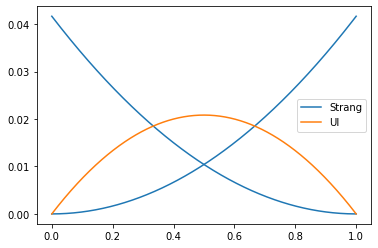

In [15]:
# Compare leading UI term contribution inside of interpolation range -> add Split step from the right side
aleph = np.linspace(0,1,1000)
plt.plot(aleph, (aleph**2/24), color='C0', label='Strang')
plt.plot(aleph, ((1-aleph)**2/24), color='C0')
plt.plot(aleph, np.abs(aleph**2-aleph)/12, color='C1', label='UI')
plt.legend()

In [16]:
# 2D UI 
h00 = H0+c1*H1+c2*H2
dh01 = d1*H1
dh10 = d2*H2
U00 = h00
U01 = h00+dh01
U10 = h00+dh10

A = Multiply(BCH_OC(U01, -U00, *oa), alpha)
B = Multiply(BCH_OC(U10, -U00, *oa), beta)             
eq_2d = Multi_BCH_OC([B, A, U00], *oa)
latex_eq_print( eq_2d, tokens=a, optimize=2, by_order=0, exp=1 )

<IPython.core.display.Latex object>

\begin{align}
\exp\Big( -i\Big(\hat{H}_{0} + \left(c_{1} + a_{1} d_{1}\right) \hat{H}_{1} + \left(c_{2} + a_{2} d_{2}\right) \hat{H}_{2} - \frac{a_{1} a_{2} d_{1} d_{2} }{2}\left[\hat{H}_{1},\hat{H}_{2}\right] + a_{1} \left(- d_{1} \left(- \left(\frac{c_{2} d_{1}}{12} - \frac{a_{1} c_{2} d_{1}}{12} + \frac{a_{2} c_{1} d_{2}}{12} - \frac{a_{1} a_{2} d_{1} d_{2}}{12}\right) \left[\left[\hat{H}_{1},\hat{H}_{2}\right],\hat{H}_{1}\right] - \frac{a_{2} d_{2} }{3}\left[\left[\hat{H}_{0},\hat{H}_{2}\right],\hat{H}_{1}\right] + \frac{a_{2} d_{2} }{4}\left[\left[\hat{H}_{1},\hat{H}_{2}\right],\hat{H}_{0}\right] + \frac{a_{2} d_{2} }{6}\left[\left[\hat{H}_{0},\hat{H}_{1}\right],\hat{H}_{2}\right]\right) + \frac{d_{1}^{2} \left(-1 + a_{1}\right) }{12}\left[\left[\hat{H}_{0},\hat{H}_{1}\right],\hat{H}_{1}\right]\right) + a_{2} \left(\frac{d_{2} \left(- c_{1} d_{2} + a_{2} c_{1} d_{2} - a_{1} c_{2} d_{1} + a_{1} a_{2} d_{1} d_{2}\right) }{12}\left[\left[\hat{H}_{1},\hat{H}_{2}\right],\hat{H}_{2}\rig

In [31]:
# 2D UI (Reverse)
h00 = H0+c1*H1+c2*H2
dh01 = d1*H1
dh10 = d2*H2
U00 = h00
U01 = h00+dh01
U10 = h00+dh10

A = Multiply(BCH_OC( -U00, U01, *oa), alpha)
B = Multiply(BCH_OC( -U00, U10, *oa), beta)
eq_2d = Multi_BCH_OC([U00, A, B], *oa)
latex_eq_print( eq_2d, tokens=a, optimize=2, by_order=0, exp=1 )

<IPython.core.display.Latex object>

\begin{align}
\exp\Big( -i\Big(\hat{H}_{0} + \left(c_{1} + a_{1} d_{1}\right) \hat{H}_{1} + \left(c_{2} + a_{2} d_{2}\right) \hat{H}_{2} + \frac{a_{1} a_{2} d_{1} d_{2} }{2}\left[\hat{H}_{1},\hat{H}_{2}\right] + a_{1} \left(\frac{d_{1} \left(c_{2} d_{1} + a_{2} c_{1} d_{2} - a_{1} c_{2} d_{1} - a_{1} a_{2} d_{1} d_{2}\right) }{12}\left[\left[\hat{H}_{1},\hat{H}_{2}\right],\hat{H}_{1}\right] + \frac{d_{1}^{2} \left(-1 + a_{1}\right) }{12}\left[\left[\hat{H}_{0},\hat{H}_{1}\right],\hat{H}_{1}\right]\right) + a_{2} \left(d_{2} \left(\frac{\left(- c_{1} d_{2} + a_{2} c_{1} d_{2} - a_{1} c_{2} d_{1} + a_{1} a_{2} d_{1} d_{2}\right) }{12}\left[\left[\hat{H}_{1},\hat{H}_{2}\right],\hat{H}_{2}\right] - \frac{a_{1} d_{1} }{12}\left[\left[\hat{H}_{1},\hat{H}_{2}\right],\hat{H}_{0}\right] + \frac{a_{1} d_{1} }{6}\left[\left[\hat{H}_{0},\hat{H}_{2}\right],\hat{H}_{1}\right]\right) + \frac{d_{2}^{2} \left(-1 + a_{2}\right) }{12}\left[\left[\hat{H}_{0},\hat{H}_{2}\right],\hat{H}_{2}\right]\right) + 

In [17]:
# 2D UI symmetric
U00_2 = Div(U00, 2)
U01_2 = Div(U01, 2)
U10_2 = Div(U10, 2)

A = Multiply(Multi_BCH_OC( [-U00_2, U01, -U00_2], *oa),  alpha)
BR = Multiply(BCH_OC( U10_2, -U00_2, *oa),beta)
BL = Multiply(BCH_OC(-U00_2,  U10_2, *oa),beta)
eq_2d_sym = Multi_BCH_OC([U00_2, BL, A, BR, U00_2], *oa)
latex_eq_print( eq_2d_sym, tokens=a, optimize=0, by_order=0, exp=1 )

<IPython.core.display.Latex object>

\begin{align}
\exp\Big( -i\Big(\hat{H}_{0} + \left(c_{1} + a_{1} d_{1}\right) \hat{H}_{1} + \left(c_{2} + a_{2} d_{2}\right) \hat{H}_{2} + \frac{a_{1} d_{1}^{2} \left(-1 + a_{1}\right) }{12}\left[\left[\hat{H}_{0},\hat{H}_{1}\right],\hat{H}_{1}\right] + \frac{a_{1} d_{1} \left(2 c_{2} d_{1} - a_{2} c_{1} d_{2} - 2 a_{1} c_{2} d_{1} - 2 a_{1} a_{2} d_{1} d_{2}\right) }{24}\left[\left[\hat{H}_{1},\hat{H}_{2}\right],\hat{H}_{1}\right] + \frac{a_{2} d_{2} \left(- c_{1} d_{2} + a_{2} c_{1} d_{2} - 4 a_{1} c_{2} d_{1} - 2 a_{1} a_{2} d_{1} d_{2}\right) }{48}\left[\left[\hat{H}_{1},\hat{H}_{2}\right],\hat{H}_{2}\right] + \frac{a_{2} d_{2}^{2} \left(-1 + a_{2}\right) }{48}\left[\left[\hat{H}_{0},\hat{H}_{2}\right],\hat{H}_{2}\right] - \frac{a_{1} a_{2} d_{1} d_{2} }{24}\left[\left[\hat{H}_{0},\hat{H}_{2}\right],\hat{H}_{1}\right] + \frac{a_{1} a_{2} d_{1} d_{2} }{12}\left[\left[\hat{H}_{0},\hat{H}_{1}\right],\hat{H}_{2}\right] + \mathcal{O}[\overset{(4)}{,}]\Big)\Big)
\end{align}


In [19]:
# 2D UI symmetric
U00_2 = Div(U00, 2)
U00_4 = Div(U00, 4)
U01_2 = Div(U01, 2)
U10_2 = Div(U10, 2)

A = Multiply(Multi_BCH_OC( [-U00_2, U01, -U00_2], *oa),  alpha)
B = Multiply(Multi_BCH_OC( [-U00_4, U10_2, -U00_4], *oa),beta)
eq_2d_sym = Multi_BCH_OC([U00_2, B, A, B, U00_2], *oa)
latex_eq_print( eq_2d_sym, tokens=a, optimize=0, by_order=0, exp=1 )

<IPython.core.display.Latex object>

\begin{align}
\exp\Big( -i\Big(\hat{H}_{0} + \left(c_{1} + a_{1} d_{1}\right) \hat{H}_{1} + \left(c_{2} + a_{2} d_{2}\right) \hat{H}_{2} + \left(- \frac{c_{2} a_{1}^{2} d_{1}^{2}}{12} + \frac{a_{1} c_{2} d_{1}^{2}}{12} + \frac{a_{2} d_{2} c_{1}^{2}}{32} - \frac{a_{2} d_{2} a_{1}^{2} d_{1}^{2}}{12} + \frac{a_{1} a_{2} c_{1} d_{1} d_{2}}{12}\right) \left[\left[\hat{H}_{1},\hat{H}_{2}\right],\hat{H}_{1}\right] + \frac{a_{2} d_{2} }{32}\left[\left[\hat{H}_{0},\hat{H}_{2}\right],\hat{H}_{0}\right] + a_{2} d_{2} \left(\frac{c_{1}}{32} + \frac{a_{1} d_{1}}{12}\right) \left[\left[\hat{H}_{0},\hat{H}_{2}\right],\hat{H}_{1}\right] - \frac{a_{2} d_{2} \cdot \left(- 3 c_{1} c_{2} + 2 c_{1} d_{2} - 8 a_{2} c_{1} d_{2} + 8 a_{1} c_{2} d_{1} + 4 a_{1} a_{2} d_{1} d_{2}\right) }{96}\left[\left[\hat{H}_{1},\hat{H}_{2}\right],\hat{H}_{2}\right] + \frac{a_{1} d_{1}^{2} \left(-1 + a_{1}\right) }{12}\left[\left[\hat{H}_{0},\hat{H}_{1}\right],\hat{H}_{1}\right] + \frac{a_{2} c_{1} d_{2} }{32}\left[\left[\ha

In [20]:
# 2D UI symmetric
U00_2 = Div(U00, 2)
U00_4 = Div(U00, 4)
U01_2 = Div(U01, 2)
U10_2 = Div(U10, 2)

A = Multiply(Multi_BCH_OC( [-U00_2, U01, -U00_2], *oa),  alpha)
B = Multiply(Multi_BCH_OC( [-U00_4, U10_2, -U00_4], *oa),beta)
eq_2d_sym = Multi_BCH_OC([U00_4, B, U00_4, A,U00_4, B, U00_4], *oa)
latex_eq_print( eq_2d_sym, tokens=a, optimize=0, by_order=0, exp=1 )

<IPython.core.display.Latex object>

\begin{align}
\exp\Big( -i\Big(\hat{H}_{0} + \left(c_{1} + a_{1} d_{1}\right) \hat{H}_{1} + \left(c_{2} + a_{2} d_{2}\right) \hat{H}_{2} + \frac{a_{1} d_{1}^{2} \left(-1 + a_{1}\right) }{12}\left[\left[\hat{H}_{0},\hat{H}_{1}\right],\hat{H}_{1}\right] + \frac{a_{1} d_{1} \left(2 c_{2} d_{1} - a_{2} c_{1} d_{2} - 2 a_{1} c_{2} d_{1} - 2 a_{1} a_{2} d_{1} d_{2}\right) }{24}\left[\left[\hat{H}_{1},\hat{H}_{2}\right],\hat{H}_{1}\right] + \frac{a_{2} d_{2} \left(- c_{1} d_{2} + a_{2} c_{1} d_{2} - 4 a_{1} c_{2} d_{1} - 2 a_{1} a_{2} d_{1} d_{2}\right) }{48}\left[\left[\hat{H}_{1},\hat{H}_{2}\right],\hat{H}_{2}\right] + \frac{a_{2} d_{2}^{2} \left(-1 + a_{2}\right) }{48}\left[\left[\hat{H}_{0},\hat{H}_{2}\right],\hat{H}_{2}\right] - \frac{a_{1} a_{2} d_{1} d_{2} }{24}\left[\left[\hat{H}_{1},\hat{H}_{2}\right],\hat{H}_{0}\right] + \frac{a_{1} a_{2} d_{1} d_{2} }{24}\left[\left[\hat{H}_{0},\hat{H}_{1}\right],\hat{H}_{2}\right] + \mathcal{O}[\overset{(4)}{,}]\Big)\Big)
\end{align}


In [ ]:
# Trotter 2D
f1 = c1 #(c1+alpha*d1)
f2 = c2 #(c2+alpha*d2)
eq_2d_trotter = Multi_BCH_OC( [ H0, f1*H1, f2*H2 ], *oa2)
latex_eq_print( eq_2d_trotter, tokens=a, optimize=2, by_order=0, exp=1 )

In [42]:
# Strang 2D
A = Multi_BCH_OC( [ H0/2, f1*H1/2, f2*H2/2 ], *oa)
B = Multi_BCH_OC( [ f2*H2/2, f1*H1/2, H0/2 ], *oa)
eq_2d_trotter_sym = Multi_BCH_OC( [ B,A ], *oa)
latex_eq_print( eq_2d_trotter_sym, tokens=a, optimize=2, by_order=0, exp=1 )

<IPython.core.display.Latex object>

\begin{align}
\exp\Big( -i\Big(\hat{H}_{0} + c_{1} \hat{H}_{1} + c_{2} \hat{H}_{2} - c_{2} \left(\frac{1}{12}\left[\left[\hat{H}_{0},\hat{H}_{2}\right],\hat{H}_{0}\right] + c_{1} \left(\frac{1}{16}\left[\left[\hat{H}_{0},\hat{H}_{2}\right],\hat{H}_{1}\right] + \frac{1}{48}\left[\left[\hat{H}_{0},\hat{H}_{1}\right],\hat{H}_{2}\right] + \frac{5 }{48}\left[\left[\hat{H}_{1},\hat{H}_{2}\right],\hat{H}_{0}\right]\right) + \frac{c_{1}^{2} }{12}\left[\left[\hat{H}_{1},\hat{H}_{2}\right],\hat{H}_{1}\right]\right) - c_{2}^{2} \left(\frac{1}{24}\left[\left[\hat{H}_{0},\hat{H}_{2}\right],\hat{H}_{2}\right] + \frac{c_{1} }{24}\left[\left[\hat{H}_{1},\hat{H}_{2}\right],\hat{H}_{2}\right]\right) - \frac{c_{1} }{12}\left[\left[\hat{H}_{0},\hat{H}_{1}\right],\hat{H}_{0}\right] - \frac{c_{1}^{2} }{24}\left[\left[\hat{H}_{0},\hat{H}_{1}\right],\hat{H}_{1}\right] + \mathcal{O}[\overset{(3)}{,}]\Big)\Big)
\end{align}


In [ ]:
# Deriving the behaviour iteratively -> for a deeper understanding of the approach

In [41]:
U000 = H0+c1*H1+c2*H2+c3*H3
dh001 = d1*H1
dh010 = d2*H2
dh100 = d3*H3
U001 = U000+dh001
U010 = U000+dh010
U100 = U000+dh100

A = Multiply(BCH_OC( U001, -U000, *oa), alpha)
B = Multiply(BCH_OC( U010, -U000, *oa), beta)
eq_3d = Multi_BCH_OC([ B, A, U000], *oa)
latex_eq_print( eq_3d, tokens=a, optimize=2, by_order=0, exp=0 )

<IPython.core.display.Latex object>

\begin{align}
\hat{H}_{0} + c_{3} \hat{H}_{3} + \left(c_{1} + a_{1} d_{1}\right) \hat{H}_{1} + \left(c_{2} + a_{2} d_{2}\right) \hat{H}_{2} - \frac{a_{1} a_{2} d_{1} d_{2} }{2}\left[\hat{H}_{1},\hat{H}_{2}\right] + a_{1} \left(- d_{1} \left(- \left(\frac{c_{2} d_{1}}{12} - \frac{a_{1} c_{2} d_{1}}{12} + \frac{a_{2} c_{1} d_{2}}{12} - \frac{a_{1} a_{2} d_{1} d_{2}}{12}\right) \left[\left[\hat{H}_{1},\hat{H}_{2}\right],\hat{H}_{1}\right] - \frac{a_{2} d_{2} }{3}\left[\left[\hat{H}_{0},\hat{H}_{2}\right],\hat{H}_{1}\right] + \frac{a_{2} d_{2} }{4}\left[\left[\hat{H}_{1},\hat{H}_{2}\right],\hat{H}_{0}\right] + \frac{a_{2} d_{2} }{6}\left[\left[\hat{H}_{0},\hat{H}_{1}\right],\hat{H}_{2}\right] - \frac{a_{2} c_{3} d_{2} }{6}\left[\left[\hat{H}_{1},\hat{H}_{3}\right],\hat{H}_{2}\right] + \frac{a_{2} c_{3} d_{2} }{3}\left[\left[\hat{H}_{2},\hat{H}_{3}\right],\hat{H}_{1}\right] + \frac{a_{2} c_{3} d_{2} }{4}\left[\left[\hat{H}_{1},\hat{H}_{2}\right],\hat{H}_{3}\right]\right) - d_{1}^{2} \left(-

In [43]:
# Single term
C = Multiply(BCH_OC( U100, -U000, *oa), delta)
latex_eq_print( C, tokens=a, optimize=2, by_order=0, exp=0)

<IPython.core.display.Latex object>

\begin{align}
a_{3} d_{3} \hat{H}_{3} + a_{3} d_{3} \left(\frac{1}{2}\left[\hat{H}_{0},\hat{H}_{3}\right] + \frac{c_{1} }{2}\left[\hat{H}_{1},\hat{H}_{3}\right] + \frac{c_{2} }{2}\left[\hat{H}_{2},\hat{H}_{3}\right]\right) - a_{3} d_{3} \left(\frac{1}{6}\left[\left[\hat{H}_{0},\hat{H}_{3}\right],\hat{H}_{0}\right] + \left(\frac{c_{3}}{6} + \frac{d_{3}}{12}\right) \left[\left[\hat{H}_{0},\hat{H}_{3}\right],\hat{H}_{3}\right] + \frac{c_{1} }{6}\left[\left[\hat{H}_{0},\hat{H}_{3}\right],\hat{H}_{1}\right] + \frac{c_{1} }{6}\left[\left[\hat{H}_{1},\hat{H}_{3}\right],\hat{H}_{0}\right] + \frac{c_{2} }{6}\left[\left[\hat{H}_{0},\hat{H}_{3}\right],\hat{H}_{2}\right] + \frac{c_{2} }{6}\left[\left[\hat{H}_{2},\hat{H}_{3}\right],\hat{H}_{0}\right] + \frac{c_{1}^{2} }{6}\left[\left[\hat{H}_{1},\hat{H}_{3}\right],\hat{H}_{1}\right] + \frac{c_{2}^{2} }{6}\left[\left[\hat{H}_{2},\hat{H}_{3}\right],\hat{H}_{2}\right] + \frac{c_{1} c_{2} }{6}\left[\left[\hat{H}_{1},\hat{H}_{3}\right],\hat{H}_{2}\right

In [30]:
# 3D UI
U000 = H0+c1*H1+c2*H2+c3*H3
dh001 = d1*H1
dh010 = d2*H2
dh100 = d3*H3
U001 = U000+dh001
U010 = U000+dh010
U100 = U000+dh100

A = Multiply(BCH_OC( U001, -U000, *oa), alpha)
B = Multiply(BCH_OC( U010, -U000, *oa), beta)
C = Multiply(BCH_OC( U100, -U000, *oa), delta)
eq_3d = Multi_BCH_OC([ C, B, A, U000], *oa)
latex_eq_print( eq_3d, tokens=a, optimize=2, by_order=0, exp=1 )

<IPython.core.display.Latex object>

\begin{align}
\exp\Big( -i\Big(\hat{H}_{0} + \left(c_{1} + a_{1} d_{1}\right) \hat{H}_{1} + \left(c_{2} + a_{2} d_{2}\right) \hat{H}_{2} + \left(c_{3} + a_{3} d_{3}\right) \hat{H}_{3} - a_{3} d_{3} \left(\frac{a_{1} d_{1} }{2}\left[\hat{H}_{1},\hat{H}_{3}\right] + \frac{a_{2} d_{2} }{2}\left[\hat{H}_{2},\hat{H}_{3}\right]\right) - \frac{a_{1} a_{2} d_{1} d_{2} }{2}\left[\hat{H}_{1},\hat{H}_{2}\right] + a_{1} \left(- d_{1} \left(- \left(\frac{c_{2} d_{1}}{12} - \frac{a_{1} c_{2} d_{1}}{12} + \frac{a_{2} c_{1} d_{2}}{12} - \frac{a_{1} a_{2} d_{1} d_{2}}{12}\right) \left[\left[\hat{H}_{1},\hat{H}_{2}\right],\hat{H}_{1}\right] - \left(\frac{c_{3} d_{1}}{12} - \frac{a_{1} c_{3} d_{1}}{12} + \frac{a_{3} c_{1} d_{3}}{12} - \frac{a_{1} a_{3} d_{1} d_{3}}{12}\right) \left[\left[\hat{H}_{1},\hat{H}_{3}\right],\hat{H}_{1}\right] - \frac{a_{2} d_{2} }{3}\left[\left[\hat{H}_{0},\hat{H}_{2}\right],\hat{H}_{1}\right] - \frac{a_{3} d_{3} }{3}\left[\left[\hat{H}_{0},\hat{H}_{3}\right],\hat{H}_{1}\right

In [29]:
# 3D UI (Reverse)
U000 = H0+c1*H1+c2*H2+c3*H3
dh001 = d1*H1
dh010 = d2*H2
dh100 = d3*H3
U001 = U000+dh001
U010 = U000+dh010
U100 = U000+dh100

A = Multiply(BCH_OC( -U000, U001, *oa), alpha)
B = Multiply(BCH_OC( -U000, U010, *oa), beta)
C = Multiply(BCH_OC( -U000, U100, *oa), delta)
eq_3d = Multi_BCH_OC([ U000, A, B, C], *oa
                     )
latex_eq_print( eq_3d, tokens=a, optimize=2, by_order=0, exp=1 )

<IPython.core.display.Latex object>

\begin{align}
\exp\Big( -i\Big(\hat{H}_{0} + \left(c_{1} + a_{1} d_{1}\right) \hat{H}_{1} + \left(c_{2} + a_{2} d_{2}\right) \hat{H}_{2} + \left(c_{3} + a_{3} d_{3}\right) \hat{H}_{3} + a_{3} d_{3} \left(\frac{a_{1} d_{1} }{2}\left[\hat{H}_{1},\hat{H}_{3}\right] + \frac{a_{2} d_{2} }{2}\left[\hat{H}_{2},\hat{H}_{3}\right]\right) + \frac{a_{1} a_{2} d_{1} d_{2} }{2}\left[\hat{H}_{1},\hat{H}_{2}\right] + \mathcal{O}[\overset{(3)}{,}]\Big)\Big)
\end{align}


In [20]:
# 3D UI symmetric
U000_2 = Div(U000, 2)
U001_2 = Div(U001, 2)
U010_2 = Div(U010, 2)
U100_2 = Div(U100, 2)

A = Multiply(Multi_BCH_OC( [-U000_2, U001, -U000_2], *oa), alpha)
BR = Multiply(BCH_OC( U010_2, -U000_2, *oa),beta)
BL = Multiply(BCH_OC(-U000_2,  U010_2, *oa),beta)
CR = Multiply(BCH_OC( U100_2, -U000_2, *oa),delta)
CL = Multiply(BCH_OC(-U000_2,  U100_2, *oa),delta)
eq_3d_sym = Multi_BCH_OC([U000_2, CL, BL, A, BR, CR, U000_2], *oa)
latex_eq_print( eq_3d_sym, tokens=a, optimize=0, by_order=0, exp=1 )

<IPython.core.display.Latex object>

\begin{align}
\exp\Big( -i\Big(\hat{H}_{0} + \left(c_{1} + a_{1} d_{1}\right) \hat{H}_{1} + \left(c_{2} + a_{2} d_{2}\right) \hat{H}_{2} + \left(c_{3} + a_{3} d_{3}\right) \hat{H}_{3} + a_{3} d_{3} \left(- \frac{a_{1} c_{2} d_{1}}{12} + \frac{a_{2} c_{1} d_{2}}{12}\right) \left[\left[\hat{H}_{1},\hat{H}_{2}\right],\hat{H}_{3}\right] + a_{3} d_{3} \left(- \frac{c_{1} d_{3}}{48} - \frac{a_{1} c_{3} d_{1}}{12} + \frac{a_{3} c_{1} d_{3}}{48} - \frac{a_{1} a_{3} d_{1} d_{3}}{24}\right) \left[\left[\hat{H}_{1},\hat{H}_{3}\right],\hat{H}_{3}\right] - \frac{a_{1} d_{1} \cdot \left(a_{3} c_{2} d_{3} - a_{2} c_{3} d_{2} + 2 a_{2} a_{3} d_{2} d_{3}\right) }{24}\left[\left[\hat{H}_{2},\hat{H}_{3}\right],\hat{H}_{1}\right] - \frac{a_{1} d_{1} \cdot \left(- 2 c_{2} d_{1} + a_{2} c_{1} d_{2} + 2 a_{1} c_{2} d_{1} + 2 a_{1} a_{2} d_{1} d_{2}\right) }{24}\left[\left[\hat{H}_{1},\hat{H}_{2}\right],\hat{H}_{1}\right] - \frac{a_{1} d_{1} \cdot \left(- 2 c_{3} d_{1} + a_{3} c_{1} d_{3} + 2 a_{1} c_{3} d_{1

In [28]:
# 3D UI symmetric
U000_2 = Div(U000, 2)
U000_4 = Div(U000, 4)
U001_2 = Div(U001, 2)
U010_2 = Div(U010, 2)
U100_2 = Div(U100, 2)

A = Multiply(Multi_BCH_OC( [-U000_2, U001, -U000_2], *oa), alpha)
B = Multiply(Multi_BCH_OC( [-U000_4, U010_2, -U000_4], *oa), beta)
C = Multiply(Multi_BCH_OC( [-U000_4, U100_2, -U000_4], *oa), delta)
eq_3d_sym = Multi_BCH_OC([U000_2, C, B, A, B, C, U000_2], *oa)
latex_eq_print( eq_3d_sym, tokens=a, optimize=0, by_order=0, exp=1 )

<IPython.core.display.Latex object>

\begin{align}
\exp\Big( -i\Big(\hat{H}_{0} + \left(c_{1} + a_{1} d_{1}\right) \hat{H}_{1} + \left(c_{2} + a_{2} d_{2}\right) \hat{H}_{2} + \left(c_{3} + a_{3} d_{3}\right) \hat{H}_{3} + \left(- \frac{a_{2} c_{3} d_{2}}{32} + \frac{a_{3} c_{2} d_{3}}{32}\right) \left[\left[\hat{H}_{2},\hat{H}_{3}\right],\hat{H}_{0}\right] + \left(\frac{a_{2} c_{1} c_{3} d_{2}}{32} - \frac{a_{1} a_{3} c_{2} d_{1} d_{3}}{12} + \frac{a_{2} a_{3} c_{1} d_{2} d_{3}}{12}\right) \left[\left[\hat{H}_{1},\hat{H}_{2}\right],\hat{H}_{3}\right] + \left(\frac{a_{3} c_{1} c_{2} d_{3}}{32} - \frac{a_{1} a_{2} c_{3} d_{1} d_{2}}{12} + \frac{a_{2} a_{3} c_{1} d_{2} d_{3}}{12} - \frac{a_{1} a_{2} a_{3} d_{1} d_{2} d_{3}}{12}\right) \left[\left[\hat{H}_{1},\hat{H}_{3}\right],\hat{H}_{2}\right] + \left(- \frac{c_{2} a_{1}^{2} d_{1}^{2}}{12} + \frac{a_{1} c_{2} d_{1}^{2}}{12} + \frac{a_{2} d_{2} c_{1}^{2}}{32} - \frac{a_{2} d_{2} a_{1}^{2} d_{1}^{2}}{12} + \frac{a_{1} a_{2} c_{1} d_{1} d_{2}}{12}\right) \left[\left[\hat{H}_

In [27]:
# 3D UI symmetric
U000_2 = Div(U000, 2)
U000_4 = Div(U000, 4)
U000_6 = Div(U000, 6)
U001_2 = Div(U001, 2)
U010_2 = Div(U010, 2)
U100_2 = Div(U100, 2)

A = Multiply(Multi_BCH_OC( [-U000_2, U001, -U000_2], *oa), alpha)
B = Multiply(Multi_BCH_OC( [-U000_4, U010_2, -U000_4], *oa), beta)
C = Multiply(Multi_BCH_OC( [-U000_4, U100_2, -U000_4], *oa), delta)
eq_3d_sym = Multi_BCH_OC([U000_6, C, U000_6, B, U000_6, A, U000_6, B, U000_6, C, U000_6], *oa)
latex_eq_print( eq_3d_sym, tokens=a, optimize=0, by_order=0, exp=1 )

<IPython.core.display.Latex object>

\begin{align}
\exp\Big( -i\Big(\hat{H}_{0} + \left(c_{1} + a_{1} d_{1}\right) \hat{H}_{1} + \left(c_{2} + a_{2} d_{2}\right) \hat{H}_{2} + \left(c_{3} + a_{3} d_{3}\right) \hat{H}_{3} + \left(- \frac{7 a_{3} c_{2} d_{3}}{288} - \frac{5 a_{2} c_{3} d_{2}}{288} - \frac{a_{2} a_{3} d_{2} d_{3}}{18}\right) \left[\left[\hat{H}_{2},\hat{H}_{3}\right],\hat{H}_{0}\right] + \left(- \frac{c_{2} a_{1}^{2} d_{1}^{2}}{12} + \frac{a_{1} c_{2} d_{1}^{2}}{12} + \frac{5 a_{2} d_{2} c_{1}^{2}}{288} - \frac{a_{2} d_{2} a_{1}^{2} d_{1}^{2}}{12}\right) \left[\left[\hat{H}_{1},\hat{H}_{2}\right],\hat{H}_{1}\right] + \left(\frac{5 a_{2} c_{1} c_{3} d_{2}}{288} - \frac{a_{1} a_{2} c_{3} d_{1} d_{2}}{36} - \frac{a_{1} a_{3} c_{2} d_{1} d_{3}}{36} + \frac{a_{2} a_{3} c_{1} d_{2} d_{3}}{36}\right) \left[\left[\hat{H}_{1},\hat{H}_{2}\right],\hat{H}_{3}\right] + \left(- \frac{7 a_{3} d_{3} c_{1}^{2}}{288} - \frac{c_{3} a_{1}^{2} d_{1}^{2}}{12} + \frac{a_{1} c_{3} d_{1}^{2}}{12} - \frac{a_{3} d_{3} a_{1}^{2} d_{1}^

In [37]:
#Strang 3D
f1 = c1
f2 = c2 
f3 = c3 
A = Multi_BCH_OC( [ H0/2, f1*H1/2, f2*H2/2 , f3*H3/2 ], *oa)
B = Multi_BCH_OC( [ f3*H3/2, f2*H2/2, f1*H1/2, H0/2 ], *oa)
eq_2d_trotter_sym = Multi_BCH_OC( [ B,A ], *oa)
latex_eq_print( eq_2d_trotter_sym, tokens=a, optimize=2, by_order=0, exp=1 )

<IPython.core.display.Latex object>

\begin{align}
\exp\Big( -i\Big(\hat{H}_{0} + c_{1} \hat{H}_{1} + c_{2} \hat{H}_{2} + c_{3} \hat{H}_{3} - c_{1} \left(\frac{1}{12}\left[\left[\hat{H}_{0},\hat{H}_{1}\right],\hat{H}_{0}\right] + c_{2} \left(\frac{1}{16}\left[\left[\hat{H}_{0},\hat{H}_{2}\right],\hat{H}_{1}\right] + \frac{1}{48}\left[\left[\hat{H}_{0},\hat{H}_{1}\right],\hat{H}_{2}\right] + \frac{5 }{48}\left[\left[\hat{H}_{1},\hat{H}_{2}\right],\hat{H}_{0}\right]\right) + c_{3} \left(\frac{1}{16}\left[\left[\hat{H}_{0},\hat{H}_{3}\right],\hat{H}_{1}\right] + \frac{1}{48}\left[\left[\hat{H}_{0},\hat{H}_{1}\right],\hat{H}_{3}\right] + \frac{5 }{48}\left[\left[\hat{H}_{1},\hat{H}_{3}\right],\hat{H}_{0}\right] + \frac{c_{2} }{16}\left[\left[\hat{H}_{1},\hat{H}_{3}\right],\hat{H}_{2}\right] + \frac{c_{2} }{48}\left[\left[\hat{H}_{1},\hat{H}_{2}\right],\hat{H}_{3}\right] + \frac{5 c_{2} }{48}\left[\left[\hat{H}_{2},\hat{H}_{3}\right],\hat{H}_{1}\right]\right) + \frac{c_{2}^{2} }{24}\left[\left[\hat{H}_{1},\hat{H}_{2}\right],\h